In [3]:
setwd('/import/liujing/data2/')

In [4]:
library(openxlsx)

Warning message:
"package 'openxlsx' was built under R version 4.2.3"


In [5]:
data<- read.xlsx("./res/CI-CTR/bulk/25-mRNA_FPKM.genename.xlsx", sheet = 1)

In [6]:
head(data,2)

,Gene_name,C10,C11,C12,C13,C14,C15,C16,C17,C18,...,CI16,CI1,CI2,CI3,CI4,CI5,CI6,CI7,CI8,CI9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ZNF480,3.046852,2.959276,1.924806,2.086426,2.358436,2.745877,2.273106,3.353977,2.609238,...,5.532627,2.837813,4.141639,4.735136,6.489764,2.851674,3.680329,7.985714,4.003843,2.993553
2,ZNF354A,2.455682,2.209675,1.816189,2.385620,3.191194,3.338612,2.912866,3.386982,3.372144,...,4.964052,5.852160,2.514873,5.180209,5.847872,4.679571,3.423737,11.670074,4.470493,4.790598


In [7]:
overla = read.table('./overlap.txt',header =T)

In [8]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [9]:
expr = data %>%  dplyr::filter(Gene_name %in%  overla$GeneName) %>%  tibble::column_to_rownames(.,'Gene_name') %>%  t()

In [10]:
rownames(expr)

[1] "C10"  "C11"  "C12"  "C13"  "C14"  "C15"  "C16"  "C17"  "C18"  "C19" 
[11] "C1"   "C2"   "C3"   "C4"   "C5"   "C6"   "C7"   "C8"   "C9"   "CI10"
[21] "CI11" "CI12" "CI13" "CI14" "CI15" "CI16" "CI1"  "CI2"  "CI3"  "CI4" 
[31] "CI5"  "CI6"  "CI7"  "CI8"  "CI9"

In [11]:
Group = c(rep('con',19),rep('CI',16))

In [12]:
colnames(expr) = gsub('-','.',colnames(expr))

In [13]:
colnames(expr)

[1] "ZNF480"   "ZNF354A"  "ZNF208"   "ZBED5"    "XRCC4"    "VCL"     
 [7] "TXN"      "TLN1"     "TFEC"     "TAF7"     "SYCP2"    "SUMO4"   
[13] "STON2"    "SPON2"    "SPOCD1"   "SH3TC2"   "SH2D2A"   "SCN9A"   
[19] "SAMD9"    "RPL34"    "RASD2"    "PTPRS"    "PRF1"     "POLR2K"  
[25] "PITPNM2"  "PILRB"    "PER1"     "PDGFA"    "PCDH1"    "OSBPL7"  
[31] "OSBPL5"   "NID1"     "NCR3"     "MLC1"     "MAP1A"    "LSM3"    
[37] "LPAR6"    "LMNA"     "KIR2DL1"  "KIFC3"    "IL2RB"    "IGJ"     
[43] "HCFC1"    "GPR56"    "GNLY"     "GAPT"     "FSD1"     "FOSB"    
[49] "FLNA"     "FAM200B"  "F2R"      "EVI2A"    "ERBB2"    "DUSP2"   
[55] "DDIT4"    "DAB2"     "CSTA"     "CLSTN1"   "CLEC2B"   "CARNS1"  
[61] "CACNA2D2" "BZRAP1"   "BMP6"     "BCL2A1"   "BAI2"     "ATP1A3"  
[67] "ATG2A"    "ARVCF"    "ARHGAP6"

In [14]:
set.seed(1234)

expr = as.data.frame(apply(expr,2,as.numeric))

expr3 = as.data.frame(cbind(Group,expr))

expr3$Group = ifelse(expr3$Group == 'CI',1,0)

expr3$Group = as.factor(expr3$Group)

 model.gene =  c('FAM200B','BCL2A1','IGJ','TXN')

expr4 = expr3 %>% dplyr::select(c(Group,model.gene))

dim(expr4)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(model.gene)

  # Now:
  data %>% select(all_of(model.gene))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


[1] 35  5

In [23]:
head(expr4,4)

,Group,FAM200B,BCL2A1,IGJ,TXN
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,3.180684,11.13562,16.570967,7.650115
2,0,4.212774,20.99854,15.639764,10.409828
3,0,3.462214,13.17759,7.572279,11.275453
4,0,3.432533,11.17819,6.509650,6.669256


In [1]:
library(caret)

data = expr4

set.seed(1)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=5,times=10)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~.,data=data,family=binomial())
    
  model_pre<-predict(model,type='response', newdata=train)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(train[,1]),model_pre)))
}
mean(auc_value)

num <- which.max(auc_value)
print(auc_value)

fold_train <- data[folds[[num]],]   
fold_test <- data[-folds[[num]],]

fold_pre <- glm(Group~.,data=data,family=binomial())

fold_predict <- predict(fold_pre,type='response',newdata=data)

roc_curve <- pROC::roc(as.numeric(data$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="ROC curve for the set with the largest AUC value")

Warning message:
"package 'caret' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


ERROR: Error in eval(expr, envir, enclos): object 'expr4' not found


In [114]:
library("autoReg")
overall.log =  glm(Group~.,data=data,family=binomial())
model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)
model3

name,desc,0 (N=19),1 (N=16),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FAM200B,Mean <U+00B1> SD,4.0 <U+00B1> 0.7,6.3 <U+00B1> 2.2,FAM200B,"5.81 (1.78-18.96, p=.004)","5.27 (1.03-26.90, p=.046)"
BCL2A1,Mean <U+00B1> SD,16.4 <U+00B1> 5.7,34.5 <U+00B1> 20.9,BCL2A1,"1.18 (1.04-1.33, p=.008)","1.12 (0.90-1.40, p=.310)"
IGJ,Mean <U+00B1> SD,21.8 <U+00B1> 17.0,70.1 <U+00B1> 72.8,IGJ,"1.04 (1.01-1.08, p=.021)","1.01 (0.97-1.06, p=.578)"
TXN,Mean <U+00B1> SD,11.7 <U+00B1> 3.5,20.2 <U+00B1> 9.7,TXN,"1.25 (1.05-1.48, p=.011)","0.86 (0.60-1.23, p=.410)"


In [247]:
library(ROCR)

dd<-datadist(data)  #开始打包数据
options(datadist="dd")

data$Group = as.factor(data$Group)

fit1 <- lrm(Group~AC132872.2+NEK2+CCNA2+SAP130 , data=data,x=T,y=T)


fit1

#  https://blog.csdn.net/Ayue0616/article/details/126601832

# cal1 <- calibrate(fit1, method='boot', B=1000) 
# plot(cal1,xlim=c(0,1.0),ylim=c(0,1.0))

### https://blog.51cto.com/u_15172991/5428282  模型图的解释参考链接

# https://ayueme.github.io/R_clinical_model/nomogram-essential.html

# https://blog.csdn.net/Dr_long1996/article/details/135446784

save(fit1,data,file = 'train.fit1.rda')

#列线图代码只能在Rstudio话

# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = T, # 对齐变量
#         subticks = T,
#         droplines = T,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )

Logistic Regression Model

lrm(formula = Group ~ AC132872.2 + NEK2 + CCNA2 + SAP130, data = data, 
    x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs            85    LR chi2      59.37     R2       0.670    C       0.927    
 1             43    d.f.             4     R2(4,85) 0.479    Dxy     0.854    
 0             42    Pr(> chi2) <0.0001    R2(4,63.7)0.581    gamma   0.855    
max |deriv| 7e-08                           Brier    0.115    tau-a   0.432    

           Coef     S.E.   Wald Z Pr(>|Z|)
Intercept   15.0083 3.4430  4.36  <0.0001 
AC132872.2  -4.0132 1.4002 -2.87  0.0042  
NEK2       -13.5900 6.0391 -2.25  0.0244  
CCNA2       -2.6275 0.9592 -2.74  0.0062  
SAP130      -0.5966 0.1819 -3.28  0.0010  


In [253]:
fit.reduce <- glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=data,family=binomial())

In [254]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example.csv",
          quote = F,row.names = F)


Waiting for profiling to be done...



In [293]:
df5

,Var,OR,Pvalue,OR_1,OR_2,OR_mean
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AC132872.2,AC132872.2,-4.01(-7.18~-1.59),0.004,-7.1788921,-1.5913535,-4.0131795
NEK2,NEK2,-13.59(-26.72~-2.64),0.024,-26.7179089,-2.6406154,-13.5899731
CCNA2,CCNA2,-2.63(-4.71~-0.92),0.006,-4.7092999,-0.9221778,-2.6275058
SAP130,SAP130,-0.6(-1~-0.27),0.001,-0.9963749,-0.2713556,-0.5965813


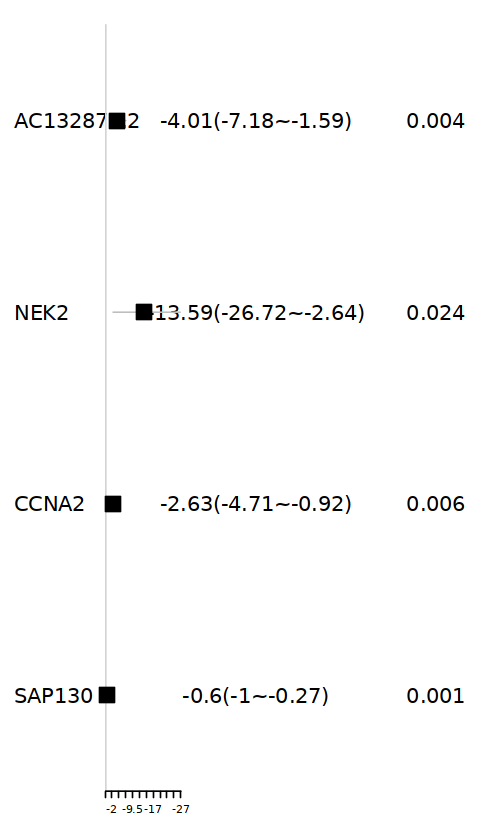

In [255]:

library(forestplot)
fp<-read.csv("forestplot_example.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

In [ ]:
# forestplot(labeltext=as.matrix(fp[,1:3]),
#            mean=fp$OR_mean,
#            lower=fp$OR_1,
#            upper=fp$OR_2,
#            zero=0,
#            boxsize=0.2,
#            lineheight = unit(7,'mm'),
#            colgap=unit(2,'mm'),
#            lwd.zero=1.5,
#            lwd.ci=2, 
#            col=fpColors(box='#458B00',
#                         summary='#8B008B',
#                         lines = 'black',
#                         zero = '#7AC5CD'),
#            xlab="OR",
#            lwd.xaxis =1,
#            txt_gp = fpTxtGp(ticks = gpar(cex = 0.85),
#                             xlab  = gpar(cex = 0.8),
#                             cex = 0.9),
#            lty.ci = "solid",
#            title = "Forestplot", 
#            line.margin = 0.08,
#            graph.pos=2)


In [ ]:
#nmfinput= data[MDD,c('MYRF','IGHJ3P','RBMS1P1','CTD.2114J12.1')] %>%  t() %>%  as.data.frame()

In [ ]:
library(NMF)

In [ ]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

In [ ]:
plot(estim.coad)

In [ ]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

In [ ]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [ ]:
library(tinyarray)

In [ ]:
data1 = data[MDD,-1] %>%  t() %>% as.data.frame()

In [ ]:
a = data1[,colnames(nmfinput)]

In [ ]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

In [ ]:
draw_pca(n,group)

In [ ]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 1)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

In [ ]:
pdat1 = pdat %>% tibble::rownames_to_column(.,'sample')

In [ ]:
bulk2.group = pdat1[,c(1,4)]
write.csv(bulk2.group,file = 'bulk2.group.csv',row.names =F)

In [ ]:
dim(bulk2.group)

In [ ]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")

In [101]:
expr3$Group = ifelse(expr3$Group == 'CI',1,0)

In [119]:
data = expr3

In [20]:
library(caret)

Warning message:
"package 'caret' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


In [21]:
data = expr4

In [29]:
set.seed(21)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=10,times=5)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~.,data=train,family=binomial())  #TNFSF14+CCNA2+MARCKS+SGOL1+SAP130
    
  model_pre<-predict(model,type='response', newdata=train)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(train[,1]),model_pre)))
}
mean(auc_value)

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases



[1] 0.9167087

In [30]:
auc_value

[1] 0.9117647 0.9495798 0.8901961 0.9019608 0.9450980 0.9327731 0.9411765
 [8] 0.8928571 0.9075630 0.8941176

In [31]:
num <- which.max(auc_value)
print(num)

[1] 2


In [34]:
fold_train <- data[folds[[num]],]   
fold_test <- data[-folds[[num]],]

fold_pre <- glm(Group~.,data=fold_train,family=binomial())

fold_predict <- predict(fold_pre,type='response',newdata=fold_test)

options(repr.plot.width = 6)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



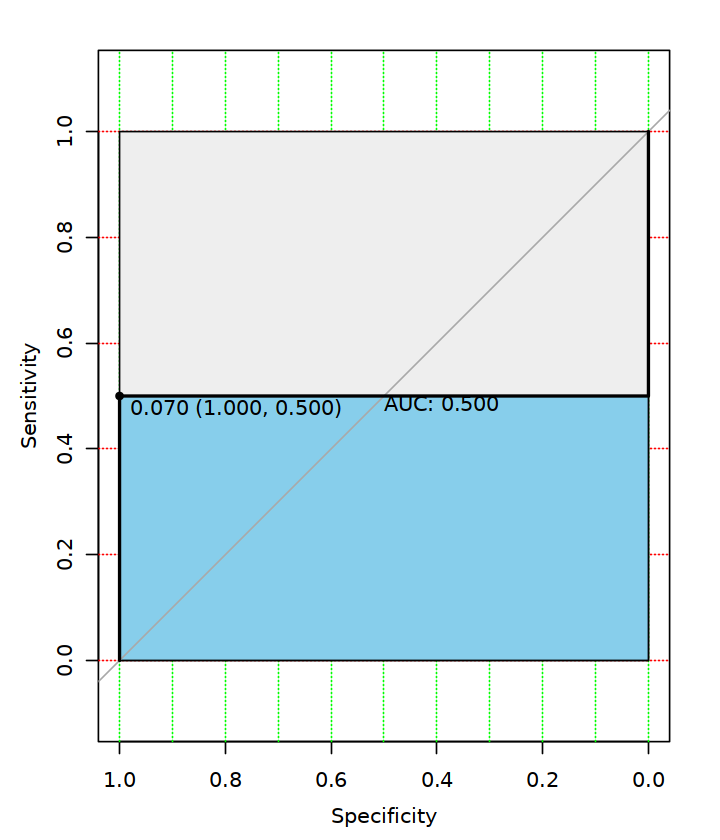

In [35]:
roc_curve <- pROC::roc(as.numeric(fold_test$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="")

In [37]:
fold_pre <- glm(Group~.,data=data,family=binomial())

fold_predict <- predict(fold_pre,type='response',newdata=data)

options(repr.plot.width = 6)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



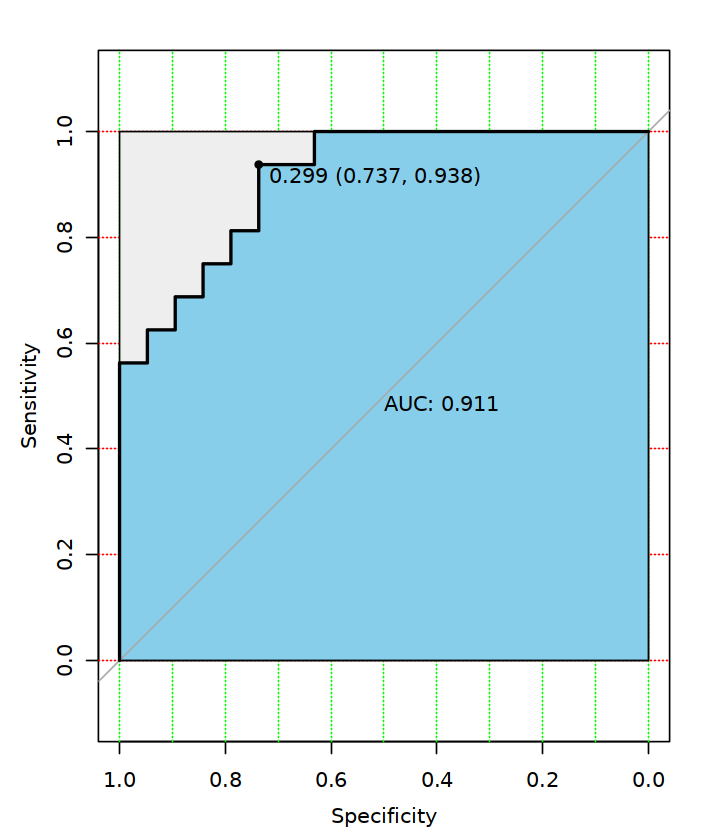

In [38]:
roc_curve <- pROC::roc(as.numeric(data$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="")

In [39]:
library(pROC)

In [42]:
pdf('ROC2.pdf',width = 6,height = 6)
rocobj1 <- plot.roc(data$Group, data$BCL2A1,percent=TRUE, levels=c(0,1),direction="<",col="#1c61b6")
rocobj2 <- lines.roc(data$Group, data$FAM200B,percent=TRUE, levels=c(0,1),direction="<", col="#008600")
rocobj3 <- lines.roc(data$Group, data$IGJ,percent=TRUE, levels=c(0,1),direction="<", col="#9C6D35")
rocobj4 <- lines.roc(data$Group, data$TXN,percent=TRUE, levels=c(0,1),direction="<", col="#9F1A70")
rocobj5 <- lines.roc(data$Group, fold_predict,percent=TRUE, levels=c(0,1),direction="<", col="#491A9F")
legend("right", legend=c(paste0("BCL2A1 ", round(rocobj1$auc/100,digits = 2)),
                               paste0("FAM200B ", round(rocobj2$auc/100,digits = 2)),
                               paste0("IGJ ", round(rocobj3$auc/100,digits = 2)),
                               paste0("TXN ", round(rocobj4$auc/100,digits = 2)),
                               paste0("fold_predict ", round(rocobj5$auc/100,digits = 2))),
       col=c("#1c61b6", "#008600","#9C6D35","#9F1A70","#491A9F"), lwd=1)
dev.off()

png 
  2